## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                           
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6124e-04 - val_loss: 0.0018
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9004e-04 - val_loss: 0.0028
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0248e-04 - val_loss: 0.0024
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3237e-04 - val_loss: 0.0025
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1473e-04 - val_loss: 0.0021
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8386e-04 - val_loss: 0.0022
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7640e-04 - val_loss: 0.0016
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2717e-04 - val_loss: 0.0017
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2543e-04 - val_loss: 0.0015
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0620e-04 - val_loss: 0.0014
Epoch 12/200
57/57 ━━━━

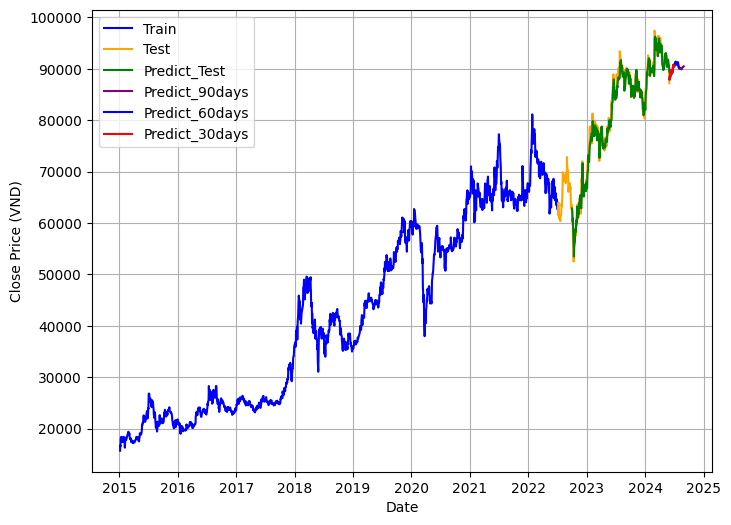

In [2]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')
plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [3]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)

Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  87971.750000
2024-06-02  88065.093750
2024-06-03  88457.710938
2024-06-04  88551.968750
2024-06-05  88351.687500
...                  ...
2024-08-25  90324.812500
2024-08-26  90391.234375
2024-08-27  90424.718750
2024-08-28  90466.281250
2024-08-29  90482.453125

[90 rows x 1 columns]


In [4]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1372.3855033067314
MAPE: 1.3098533064216722 %
MAE: 1036.1641582414215


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                          
model.add(Dense(n_forecast))                                      
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 7.4105e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 8.0646e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9237e-04 - val_loss: 8.0313e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3102e-04 - val_loss: 8.0810e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7426e-04 - val_loss: 7.6031e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2879e-04 - val_loss: 6.7310e-04
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0313e-04 - val_loss: 6.4914e-04
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6149e-04 - val_loss: 5.7752e-04
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2011e-04 - val_loss: 5.5643e-04
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9977e-04 - val_loss: 5.6306e-04
Epo

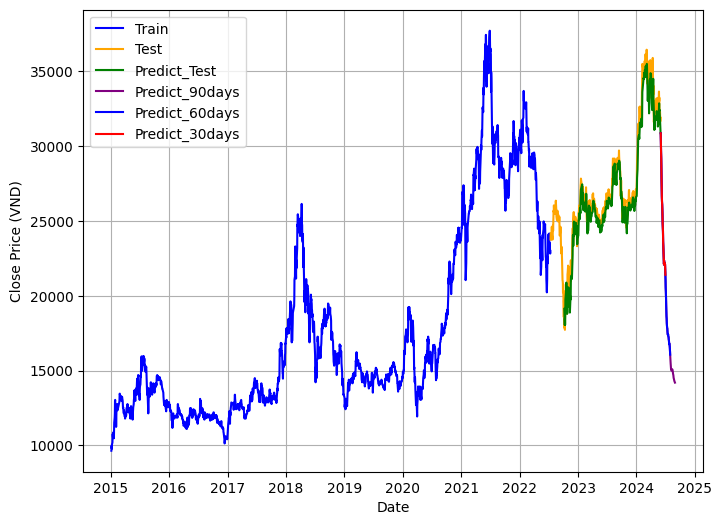

In [6]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')
plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [7]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  30863.958984
2024-06-02  30312.390625
2024-06-03  29628.287109
2024-06-04  29189.427734
2024-06-05  28516.195312
...                  ...
2024-08-25  14310.617188
2024-08-26  14271.934570
2024-08-27  14245.219727
2024-08-28  14221.075195
2024-08-29  14191.129883

[90 rows x 1 columns]


In [8]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 815.2140657029537
MAPE: 2.3889669907482336 %
MAE: 650.6219151130807


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0085 - val_loss: 0.0014
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0330e-04 - val_loss: 0.0011
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4928e-04 - val_loss: 9.0248e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6259e-04 - val_loss: 0.0015
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7617e-04 - val_loss: 0.0015
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3857e-04 - val_loss: 0.0015
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1635e-04 - val_loss: 0.0015
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9751e-04 - val_loss: 0.0015
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7268e-04 - val_loss: 0.0014
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5185e-04 - val_loss: 0.0013
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4055e-04 - val_loss: 0.0012
Epoch 12/200
57/57 ━━━━━━━━━━━━

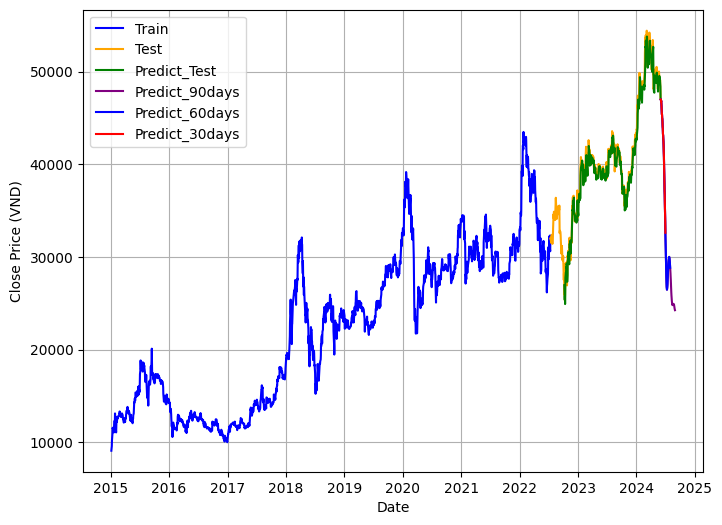

In [10]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')
plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [11]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  46986.324219
2024-06-02  46970.179688
2024-06-03  46780.800781
2024-06-04  46849.035156
2024-06-05  46523.203125
...                  ...
2024-08-25  24644.753906
2024-08-26  24525.181641
2024-08-27  24403.773438
2024-08-28  24332.591797
2024-08-29  24257.162109

[90 rows x 1 columns]


In [12]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 896.7947803422473
MAPE: 1.6360616234494054 %
MAE: 655.1872564562958
